# Digit Recognizer with LeNet 5

## Data Preprocessing

### 1. Import libraries

In [1]:
import os
import copy
import random
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split

### 2. Loading dataset from directory

In [2]:
# Mount Google drive to Colab to serve as local directory
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Load the data
dir_root = "/content/drive/MyDrive/Kaggle/Digit_Recognizer/Data/digit-recognizer"
train_dir = os.path.join(dir_root, "train.csv")
train = pd.read_csv(train_dir, dtype=np.float32)
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Split features and labels
X_train = train.loc[:, train.columns != "label"]
Y_train = train.label

### 3. Check for data inbalance or missing value

In [5]:
# Check if contain null features
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

1.0    4684
7.0    4401
3.0    4351
9.0    4188
2.0    4177
6.0    4137
0.0    4132
4.0    4072
8.0    4063
5.0    3795
Name: label, dtype: int64


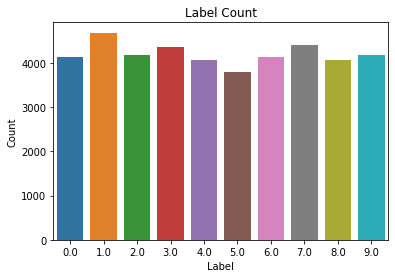

In [6]:
# Check for counts
label_count = Y_train.value_counts()
print(label_count)
g = sns.countplot(x=Y_train)
g = g.set(xlabel="Label", ylabel="Count", title="Label Count")

### 4. Normalization and transformation

In [7]:
'''
Perform grayscale normalization to 
1. Reduce illumination differences
2. Increase CNN covergence rate
'''
X_train = X_train / 255.0

In [8]:
# Split the training and test set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.values, 
    Y_train.values, 
    test_size=0.1, 
    random_state=42
    )

# Reshape input image
X_train = X_train.reshape((-1, 1, 28, 28))
X_train = np.squeeze(X_train, axis=1)
X_test = X_test.reshape((-1, 1, 28, 28))
X_test = np.squeeze(X_test, axis=1)

# Transform from numpy arrays to tensors
Y_train = torch.from_numpy(Y_train).type(torch.FloatTensor)
Y_test = torch.from_numpy(Y_test).type(torch.FloatTensor)

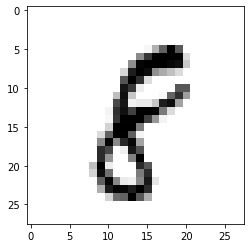

In [9]:
# Example
g = plt.imshow(X_train[0][:,:], cmap="binary")

In [10]:
# Define MNIST data class
transform_train = transforms.Compose([transforms.ToTensor()])
class MNIST(Dataset):
    def __init__(self, X, Y, Transform):
        self.X = X
        self.transform = Transform
        self.Y = Y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.transform(self.X[index]), self.Y[index]

batch_size_train, batch_size_test = 64, 1000
train_set = MNIST(X_train, Y_train, transform_train)
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)

test_set = MNIST(X_test, Y_test, transform_train)
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=False)

## Convolutional Neural Network

### 1. Create CNN Model

In [11]:
# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda


In [12]:
latent_feature = 10

class LeNet5(nn.Module):
    '''
    This implementation follow LeNet5's design from "Gradient-based learning
    applied to document recognition" by Y.Lecun with several modifications.
    
    - Two 3x3 filters replaced single 5x5 filter in conv2d layer 3
    - Batch normalization added
    - ReLU activation function replaced tanh
    - More channels added
    - Dropout added
    '''
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=32),
            nn.Dropout2d(p=0.25),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.Dropout2d(p=0.25),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=3136, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.BatchNorm1d(num_features=256),
            nn.Linear(in_features=256, out_features=latent_feature)
        )
        
    def forward(self, x):
        
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)

        return x

### 2. Instantiate model, loss function, and optimizer

In [13]:
# Instantiate model and move to GPU if available
model = LeNet5()
LeNet5_classifier = model.to(device)

# Instantiate loss function
loss_fn = nn.NLLLoss()

# Instantiate optimizer
learning_rate = 0.001
optimizer = optim.Adam(LeNet5_classifier.parameters(), lr=learning_rate)

# Instantiate number of epoch, losses, score
max_epoch = 30
train_losses, test_losses = [], []
acc_list = []
best_score = 0
best_model = None

### 3. Train and test the model

In [14]:
def train(classifier, epoch):

    classifier.train()

    for idx, (images, labels) in enumerate(train_loader):
        
        images = images.to(device, dtype=torch.float)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = classifier(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        if idx % 10 == 0: # Record output every 10 batches
            train_losses.append(loss.item())
        if idx % 100 == 0: # Visualize output every 100 batches
            print(f"Epoch {epoch}: [{idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}")

In [15]:
def test(classifier, epoch, best_score):
    
    classifier.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            
            images = images.to(device, dtype=torch.float)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)

            output = classifier(images)
            test_loss += loss_fn(output, labels).item()
            pred = output.data.max(1, keepdim=True)[1] # Get estimate of result by looking at largest class value
            correct += pred.eq(labels.data.view_as(pred)).sum()
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc_val = correct/len(test_loader.dataset)
    acc_val = acc_val.cpu()
    acc_list.append(acc_val)
    print(f"Test result on epoch {epoch}: Avg loss is {test_loss:.6f}, Accuracy: {100.*acc_val:.6f}%", end=" ")
    if best_score <= acc_val:
        best_score = acc_val
        best_model = copy.deepcopy(classifier)
        print("(New Best Score)")
    else:
        print()
    return best_score

In [16]:
for epoch in range(1, max_epoch+1):
    train(LeNet5_classifier, epoch)
    best_score = test(LeNet5_classifier, epoch, best_score)

Epoch 1: [0/37800] Loss: 2.471352
Epoch 1: [6400/37800] Loss: 0.172676
Epoch 1: [12800/37800] Loss: 0.108736
Epoch 1: [19200/37800] Loss: 0.212184
Epoch 1: [25600/37800] Loss: 0.073103
Epoch 1: [32000/37800] Loss: 0.087433
Test result on epoch 1: Avg loss is 0.000058, Accuracy: 98.619041% (New Best Score)
Epoch 2: [0/37800] Loss: 0.031387
Epoch 2: [6400/37800] Loss: 0.081721
Epoch 2: [12800/37800] Loss: 0.040203
Epoch 2: [19200/37800] Loss: 0.019005
Epoch 2: [25600/37800] Loss: 0.011277
Epoch 2: [32000/37800] Loss: 0.067327
Test result on epoch 2: Avg loss is 0.000050, Accuracy: 98.761902% (New Best Score)
Epoch 3: [0/37800] Loss: 0.097938
Epoch 3: [6400/37800] Loss: 0.019670
Epoch 3: [12800/37800] Loss: 0.038699
Epoch 3: [19200/37800] Loss: 0.049176
Epoch 3: [25600/37800] Loss: 0.068788
Epoch 3: [32000/37800] Loss: 0.044023
Test result on epoch 3: Avg loss is 0.000036, Accuracy: 99.000000% (New Best Score)
Epoch 4: [0/37800] Loss: 0.099521
Epoch 4: [6400/37800] Loss: 0.029352
Epoch 4:

## Visualization Result

In [17]:
# Create graph object
fig = go.Figure()

label_name = ["Loss", "Accuracy"]
colors = ["rgb(67, 67, 67)", "rgb(49, 130, 189)"]
line_size = [2, 2]
mode_size = [8, 8]

# X is number of epoch, y is loss and accuracy
x_data = np.vstack((np.arange(1, max_epoch+1),)*2)
y_data = np.array([test_losses, acc_list])

# Adding line
for i in range(0, 2):
    fig.add_trace(go.Scatter(
        x=x_data[i],
        y=y_data[i],
        mode="lines",
        name=label_name[i],
        line=dict(color=colors[i], width=line_size[i]),
        connectgaps=True
    ))
    
    fig.add_trace(go.Scatter(
        x=[x_data[i][0], x_data[i][-1]],
        y=[y_data[i][0], y_data[i][-1]],
        mode="markers",
        marker=dict(color=colors[i], size=mode_size[i])
    ))

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=False,
    ),
    autosize=False,
    margin=dict(
        autoexpand=False,
        l=100,
        r=150,
        t=100,
    ),
    showlegend=True,
    plot_bgcolor='white'
)

annotations = []

# Adding labels
for y_trace, label, color in zip(y_data, label_name, colors):
    # Label left side
    annotations.append(dict(
        xref='paper', 
        x=0.05, 
        y=y_trace[0],
        xanchor='right', 
        yanchor='middle',
        text=label + ' {:.2f}'.format(y_trace[0]),
        font=dict(family='Arial', size=16),
        showarrow=False
        ))
    # Label right side
    annotations.append(dict(
        xref='paper', 
        x=0.95, 
        y=y_trace[max_epoch-1],
        xanchor='left', 
        yanchor='middle',
        text='{:.4f}%'.format(y_trace[max_epoch-1]),
        font=dict(family='Arial', size=16),
        showarrow=False
        ))

# Adding title
annotations.append(dict(
    xref='paper', 
    yref='paper', 
    x=0.0, 
    y=1.05,
    xanchor='left', 
    yanchor='bottom',
    text='Training Loss and Accuracy',
    font=dict(family='Arial',
    size=30,
    color='rgb(37,37,37)'),
    showarrow=False
    ))

# Source
annotations.append(dict(
    xref='paper', 
    yref='paper', 
    x=0.5, y=-0.1,
    xanchor='center', 
    yanchor='top',
    text='Epochs',
    font=dict(family='Arial', size=12, color='rgb(150,150,150)'),
    showarrow=False
    ))

fig.update_layout(annotations=annotations,height=600, width=1000)

fig.show()